Import Necessary Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Load the Data

In [2]:
# Fetch historical stock data (Apple Inc. as an example)
stock_symbol = 'AAPL'
stock_data = yf.download(stock_symbol, start="2010-01-01", end="2025-01-01")

# Show the first few rows of the stock data
stock_data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
2010-01-05,6.451467,6.487880,6.417460,6.458087,601904800
2010-01-06,6.348845,6.477044,6.342225,6.451465,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800


Data Preprocessing

In [3]:
# Use only the 'Close' price for prediction
data = stock_data[['Close']]

# Normalize the stock prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a data structure with 60 timesteps and 1 output
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])  # Use the last 60 days' prices as input
    y.append(scaled_data[i, 0])       # Predict the next day's price

X, y = np.array(X), np.array(y)

# Reshape X to be compatible with LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2971, 60, 1)
X_test shape: (743, 60, 1)


  Build the model

In [4]:
# Build the LSTM model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0046
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.0326e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 8.6551e-05
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 1.0806e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 8.8469e-05
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 7.9156e-05
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 7.0019e-05
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.0409e-05
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1.0108e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 5.9549e-05


Make predictions

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


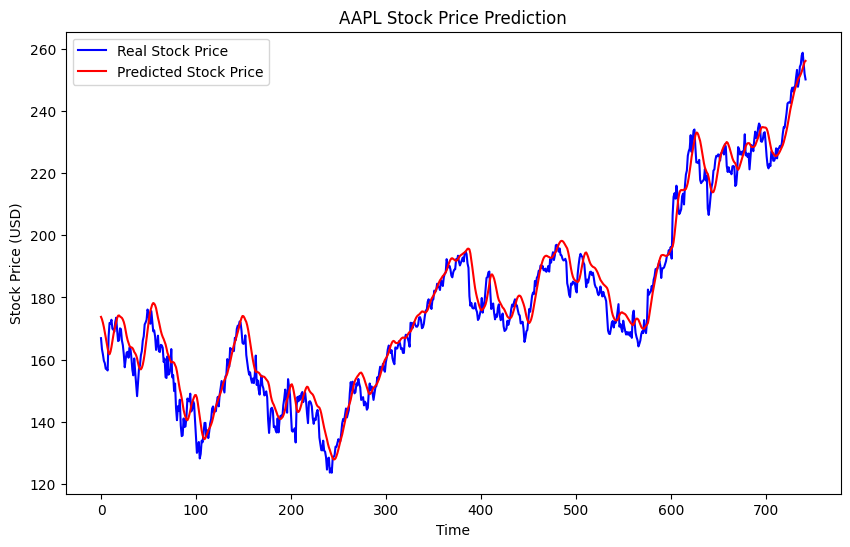

In [5]:
# Make predictions on the test data
predictions = model.predict(X_test)

# Invert the scaling of the predictions and the real prices to get actual stock prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Real Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


Evaluate the model

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')


Mean Absolute Error (MAE): 4.431744253330565
Mean Squared Error (MSE): 31.546700210021438
